<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/texture_nca_pytorch_random_affine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

# Learning affine transformations with neural cellular automata & moderngl

In [1]:
!pip install moderngl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.9 MB/s eta 0:00:00


In [2]:
gridgl = """
  // %%VARIABLE%% will be replaced with consts by python code
  // author: minu jeong

  #version 430

  #define X %%X%%
  #define Y %%Y%%
  #define Z %%Z%%
  #define W %%W%%
  #define H %%H%%

  #define GS %%GS%%
  #define GCR %%GCR%%
  #define GCG %%GCG%%
  #define GCB %%GCB%%

  #define TH %%TH%%
  #define TR %%TR%%


  layout(local_size_x=X, local_size_y=Y, local_size_z=Z) in;
  layout (std430, binding=0) buffer in_0
  {
      vec4 inxs[1];
  };

  layout (std430, binding=1) buffer out_0
  {
      vec4 outxs[1];
  };

  layout (std430, binding=2) buffer uv_0
  {
      vec2 uvs[1];
  };

  #define win_width 5
  #define win_height 5
  #define win_wh 25
  vec4 window[win_wh] = {
      // should manually initialize this
      vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
      vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
      vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
      vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
      vec4(0), vec4(0), vec4(0), vec4(0), vec4(0)
  };

  void main()
  {
      // define consts
      const int x = int(gl_LocalInvocationID.x);
      const int y = int(gl_WorkGroupID.x);
      const int frag_i = x + y * W;

      vec2 uv = vec2(x, y);
  
      float gridx = fract(uv.x / W * GS + TR) > TH ? 1.:0.;
      float gridy = fract(uv.y / H * GS + TR) > TH ? 1.:0.;

      vec3 color;
      color = vec3(GCR, GCG, GCB) * (gridx + gridy);

      //color = vec3(uv, 1.);

      //color = vec3(sin(uv.x / 256), 0, sin(uv.y / 256));
      // write to buffer
      outxs[frag_i] = vec4(color.xyz, 1.0);
  }
  """

with open('grid.gl', 'w') as f:
  f.write(gridgl)

In [3]:
import os

import moderngl
import numpy as np
import imageio  # for output



def source(uri, consts):
    ''' read gl code '''
    with open(uri, 'r') as fp:
        content = fp.read()

    # feed constant values
    for key, value in consts.items():
        content = content.replace(f"%%{key}%%", str(value))
    return content


context = moderngl.create_context(standalone=True, backend='egl')


def make_grid(r, g, b, s, h=256, w=256, filename='grid.gl', outname='output.png'):

  # W = X * Y  // for each run, handles a row of pixels
  # execute compute shader for H times to complete
  W = 256
  H = 256
  X = W
  Y = 1
  Z = 1

  consts = {
      "W": W,
      "H": H,
      "X": X + 1,
      "Y": Y,
      "Z": Z,
      "GCR": r,
      "GCG": g,
      "GCB": b,
      "GS": s,

      "TH": .95,
      "TR": .495
  }

  SOURCE_PATH = os.path.dirname('/content/')

  glsl_file = os.path.join(SOURCE_PATH, filename)


  compute_shader = context.compute_shader(source(glsl_file, consts))

  # init buffers
  buffer_a_data = np.random.uniform(0.0, 1.0, (H, W, 4)).astype('f4')
  buffer_a = context.buffer(buffer_a_data)
  buffer_b_data = np.zeros((H, W, 4)).astype('f4')
  buffer_b = context.buffer(buffer_b_data)

  imgs = []
  last_buffer = buffer_b
  toggle = True
  buffer_a.bind_to_storage_buffer(1 if toggle else 0)
  buffer_b.bind_to_storage_buffer(0 if toggle else 1)

  # toggle 2 buffers as input and output
  last_buffer = buffer_a if toggle else buffer_b

  # local invocation id x -> pixel x
  # work groupid x -> pixel y
  # eg) buffer[x, y] = gl_LocalInvocationID.x + gl_WorkGroupID.x * W
  compute_shader.run(group_x=H, group_y=1)

  # print out
  output = np.frombuffer(last_buffer.read(), dtype=np.float32)
  output = output.reshape((H, W, 4))
  output = np.multiply(output, 255).astype(np.uint8)
  # output = np.multiply(output, 128).astype(np.uint8)
  imageio.imwrite(outname, output, "PNG")


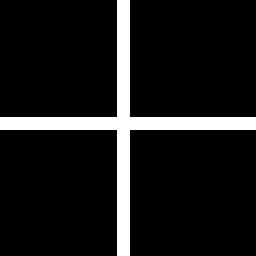

In [4]:
make_grid(1, 1, 1, 1, outname='world.png')
from PIL import Image as PILImage
PILImage.open('world.png')

In [5]:
#@title Imports and Notebook Utilities

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def prep(t):
  return t.permute([0, 2, 3, 1]).cpu()

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-621fc7c2-1532-7819-8ece-8a3b2e25978d)


In [6]:
import torch
import torchvision.models as models
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')

from torchvision.transforms.functional import affine


In [7]:
make_grid(1, 1, 1, 1, outname='center.png')
center = torch.tensor(imread('center.png', max_size=128)[...,:3]).permute([-1, 0, 1])

def proj(x, angle=45, translate=(0,0), scale=1, shear=0.):
  """projector-camera system simulator. 
  apply linear transformations to input"""

  projected = affine(x, angle, translate, scale, shear)

  # projected[:, :3, ...] = torch.clip(projected[:, :3, ...] + world.repeat([x.shape[0], 1, 1, 1]), 0., 1.)

  return projected

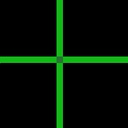

In [250]:
def make_world():
  init_pars = np.array((*np.random.rand(3), np.random.rand() * 4))
  pars = init_pars
  make_grid(*pars, outname='world.png')
  world = torch.tensor(imread('world.png', max_size=128)[...,:3]).permute([-1, 0, 1])
  return world

world = make_world()
imshow(prep(world.unsqueeze(0))[0])

In [179]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)


def channel_attention(y, downscale, upscale):

  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = downscale(y)
  y = upscale(y)
  return torch.nn.functional.sigmoid(y)


class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96, a=0, t=(0,0), sc=1, sh=0):
    super().__init__()
    self.chn = chn

    g = chn*4
    self.w1 = torch.nn.Conv2d(g, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)#, groups=self.chn)
    self.w2.weight.data.zero_()

    self.angle=a
    self.translate=t
    self.scale=sc
    self.shear=sh


    self.downscale = torch.nn.Conv2d(chn*4, chn*2, 3, bias=False)
    self.upscale = torch.nn.Conv2d(chn*2, chn*4, 1, bias=False)

    self.upd = torch.nn.Conv2d(chn, chn, 1)
    

  def forward(self, x, update_rate=0.8):
    
    y = perception(x)

    b, g, h, w = y.shape

    y = y * channel_attention(y, self.downscale, self.upscale)

    y = self.w1(y)
    y = self.w2(torch.nn.functional.relu(y))

    # update_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    update_mask = (update_rate + torch.nn.functional.sigmoid(self.upd(y))).floor()
    update = y * update_mask \
    
    # incremental update
    update += x

    # transform and feedback
    projected = proj(x[:,-3:,...], self.angle, self.translate, self.scale, self.shear)
    return torch.cat([projected, update[:, 3:, ...]], 1)

  def seed(self, n, sz=128):
    # return torch.cat([imt.repeat([n, 1, 1, 1]), torch.rand(n, self.chn -3 , sz, sz) / 10.], 1) # something seen on cam feed
    # return torch.cat([world.repeat([n, 1, 1, 1]), torch.rand(n, self.chn -6 , sz, sz) / 10., center.repeat([n, 1, 1, 1])], 1)
    # return torch.cat([torch.rand(n, self.chn -3 , sz, sz) / 10., center.repeat([n, 1, 1, 1])], 1)

    # return torch.zeros((n, self.chn, sz, sz))
    # return torch.cat([torch.zeros(n, self.chn - 6, sz, sz), world.repeat([n, 1, 1, 1]), torch.zeros(n, 3, sz, sz)], 1)
    return torch.cat([torch.zeros(n, self.chn-3, sz, sz), world.repeat([n, 1, 1, 1])], 1)


def to_rgb(x):
  return x[...,:3,:,:] # +0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 17532


# learning affine transform


In [215]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3 * 3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)
loss_log = []

In [216]:
with torch.no_grad():
  pool = ca.seed(256)

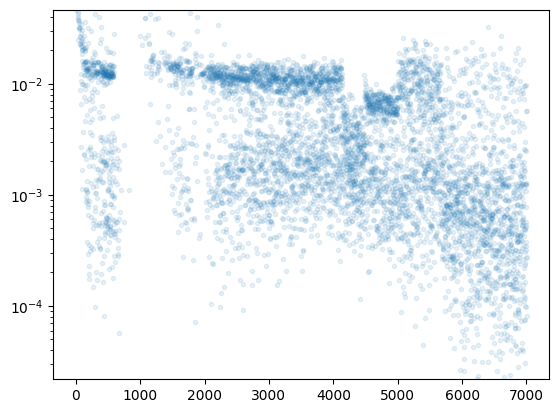

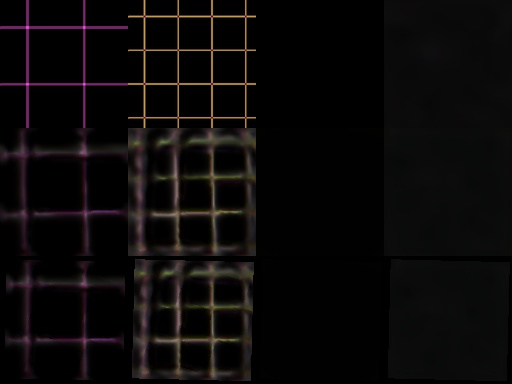

epoch: 7050  loss: 0.00021587309311144054  lr: 0.0009

KeyboardInterrupt: ignored

In [254]:
#@title training loop {vertical-output: true}
# init_pars = np.array((*np.random.rand(3), np.random.rand() * 4))
# pars = init_pars
# world = torch.tensor(imread('world.png', max_size=128)[...,:3]).permute([-1, 0, 1])

for i in range(4000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)

    x = pool[batch_idx]

    if i%8 == 0:
      # pars = init_pars + np.array((*np.random.rand(3), np.random.rand() * 4)) / 10 * np.random.choice([-1, 1], 4)
      # make_grid(*pars, outname='world.png')
      # world = torch.tensor(imread('world.png', max_size=128)[...,:3]).permute([-1, 0, 1])

      x[:2] = ca.seed(2)
      x[:2, -3:,...] = torch.stack([make_world() for _ in range(2)])
      # x = ca.seed(4)

  # random affine transform coefs
  ca.angle = np.random.choice(np.linspace(-10, 10))
  ca.translate = tuple(np.random.choice(np.linspace(-1, 1)) for _ in range(2))
  ca.scale = np.random.choice(np.linspace(.8, 1.2))
  ca.shear = 0.

  step_n = np.random.randint(32, 96)

  projected0 = x[:,-3:,...]  # initial output to projector
  cam_feed0 = to_rgb(ca(x)[:,:3,...])  

  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)

  projected = x[:,-3:,...]  # output to projector
  cam_feed = to_rgb(x[:,:3,...])  # input to ca


  # losses

  loss = 0.;
  # loss = (projected.mean() - projected0.mean()).abs()   # mass conservation
  # loss += (cam_feed0 - cam_feed).abs().mean()  # stable cam feed

  # reversed = affine(cam_feed - world.repeat([4,1,1,1]), -a, (-t[0], -t[1]), 1/sc, 1/sh if sh else 0)
  # loss = (projected - reversed).square().mean()

  # loss += (cam_feed - world.repeat([4,1,1,1])).square().mean()
  loss += (cam_feed - projected0).square().mean()

  overflow_loss = (x-x.clamp(0., 1.0)).square().mean()
  loss += overflow_loss

  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()

      imshow(np.vstack([np.hstack(prep(ims)) for ims in (projected0, cam_feed0, projected, cam_feed)]))
    if i%10 == 0:
      print('\repoch:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')


In [ ]:
 torch.save(ca, 'af_{}.pt'.format(len(loss_log)))

In [ ]:
world = imread('https://d7hftxdivxxvm.cloudfront.net/?resize_to=fit&width=800&height=797&quality=80&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2FCgsDHhK_bgFmGWJ6jfye8A%2Fnormalized.jpg', max_size=128)[...,:3]
world = torch.tensor(world).permute([-1, 0, 1])

In [255]:


#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, sz=128)
  x[0, -3:, ...] = make_world()  # torch.tensor(imread('https://d7hftxdivxxvm.cloudfront.net/?resize_to=fit&width=800&height=797&quality=80&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2FCgsDHhK_bgFmGWJ6jfye8A%2Fnormalized.jpg', max_size=128)[...,:3]).permute(2, 0, 1)
  ca.angle = np.random.choice(np.linspace(-10, 10))
  ca.translate = tuple(np.random.choice(np.linspace(-1, 1)) for _ in range(2))
  ca.scale = np.random.choice(np.linspace(.8, 1.2))
  ca.shear = 0.



#   x = torch.cat([makez2(1, sz=128), torch.zeros((1, 12-3, 128, 128))], 1)

  # initial frame
  img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])
  vid.add(zoom(img, 2))


  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 16) // 2 + 1
    # step_n = 4
    for i in range(step_n):
      x[:] = ca(x)

    # img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])

    vid.add(zoom(img, 2))

  for k in tnrange(300, leave=False):



  0%|          | 0/300 [00:00<?, ?it/s]

In [229]:
#@title projection only {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, sz=128)
  x[:, :3, ...] = world 


  for k in tnrange(30, leave=False):
    step_n = min(2**(k//30), 16) // 2 + 1
    # step_n = 4
    for i in range(step_n):
      x[:] = proj(x,ca.angle,ca.translate, ca.scale,ca.shear)

    img = to_rgb(x)[0].permute(1, 2, 0).cpu()
    # img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])

    vid.add(zoom(img, 2))

  for k in tnrange(30, leave=False):



  0%|          | 0/30 [00:00<?, ?it/s]